In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
with open('gru_outputs_1000000_episodes_1eLR_500units_/test_sessions_data.pkl', 'rb') as file:
    test_sessions_data = pickle.load(file)

with open('gru_outputs_1000000_episodes_1eLR_500units_/test_tasks.txt', 'r') as file:
    test_tasks = [list(map(int, line.strip()[1:-1].split(', '))) for line in file.readlines()]

In [3]:
# Create a list to store the dataframes
dataframes = []

# Iterate through each session in test_sessions_data
for session in test_sessions_data:
    # Convert the list of dictionaries (timepoints) to a dataframe
    df = pd.DataFrame(session)
    dataframes.append(df)

In [4]:
import seaborn as sns

# Initialize a dictionary to store the heatmaps for each unit
heatmaps = {}

# Iterate through each unit in the activation
for unit in range(len(dataframes[0]['activation'][0])):
    # Initialize a 5x4 matrix to store the average activations
    avg_activations = np.zeros((len(dataframes), 4))
    
    # Iterate through each session (dataframe)
    for i, df in enumerate(dataframes):
        # Filter the dataframe by reward labels
        for j, label in enumerate(['A', 'B', 'C', 'D']):
            # Get the activations for the current unit where the reward label is the current label
            activations = df[df['reward_label'] == label]['activation'].apply(lambda x: x[unit])
            # Calculate the average activation and store it in the matrix
            if not activations.empty:
                avg_activations[i, j] = activations.mean()
    
    # # Create a heatmap for the current unit
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(avg_activations, annot=True, xticklabels=['A', 'B', 'C', 'D'], yticklabels=[f'Session {i+1}' for i in range(5)])
    # plt.title(f'Heatmap for Unit {unit}')
    # plt.xlabel('Reward Label')
    # plt.ylabel('Session')
    # plt.show()
    
    # # Store the heatmap in the dictionary
    heatmaps[unit] = avg_activations

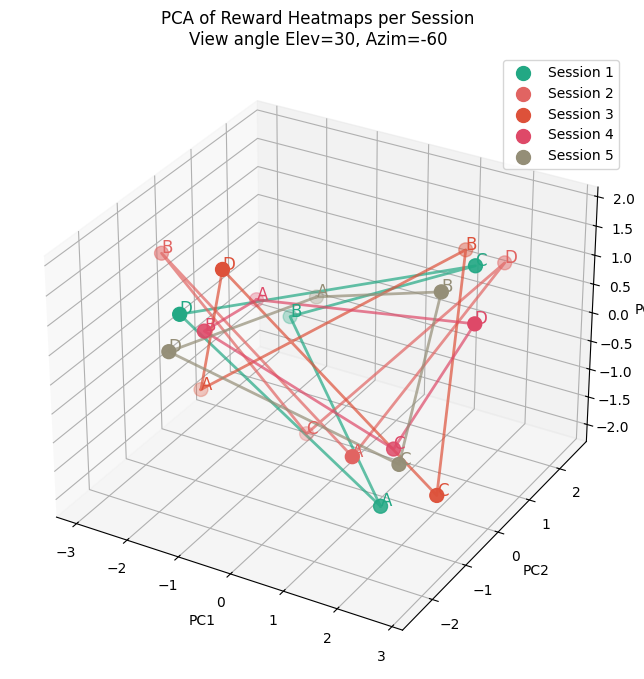

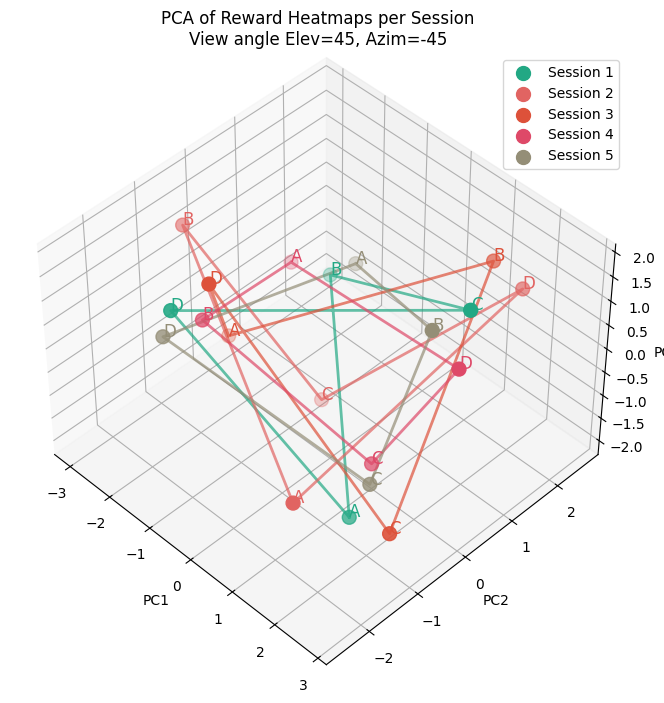

In [5]:
from sklearn.decomposition import PCA

# Define missing variables
view_angles = [(30, -60), (45, -45)]  # modify as needed
reward_labels = ['A', 'B', 'C', 'D']
cmap_list = [plt.cm.viridis, plt.cm.plasma, plt.cm.inferno, plt.cm.magma, plt.cm.cividis]

for elev, azim in view_angles:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    for session_id in range(5):
        # For each unit, select the row corresponding to current session (each heatmap is 5x4)
        session_data = np.vstack([hm[session_id, :] for hm in heatmaps.values()])  # shape: (#units, 4)
        
        # Transpose: now each row corresponds to a reward state
        X_session = session_data.T  # shape: (4, #units)
        
        # Run PCA on the 4 observations
        pca_session = PCA(n_components=3)
        X_session_pca = pca_session.fit_transform(X_session)  # shape: (4, 3)
        
        # Get a representative color from the colormap for this session.
        color = cmap_list[session_id](0.6)
        
        # Scatter the 4 points.
        ax.scatter(X_session_pca[:, 0], X_session_pca[:, 1], X_session_pca[:, 2],
                   s=100, color=color, label=f'Session {session_id+1}')
        
        # Annotate with reward labels.
        for i, (x, y, z) in enumerate(X_session_pca):
            ax.text(x, y, z, reward_labels[i], fontsize=12, color=color)
        
        # Draw connections between A-B, B-C, C-D, D-A.
        indices = [0, 1, 2, 3, 0]
        pts = X_session_pca[indices, :]
        ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], color=color, lw=2, alpha=0.7)
    
    ax.set_title(f"PCA of Reward Heatmaps per Session\nView angle Elev={elev}, Azim={azim}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.legend()
    ax.view_init(elev=elev, azim=azim)
    plt.show()


Number of sessions with D->A transition: 40
Number of sessions with D->(B or C) transition: 0

[D->A] Mean actual path length: 3.85
[D->A] Mean theoretical distance: 2.00
[D->A] Mean efficiency (theoretical/actual): 0.68


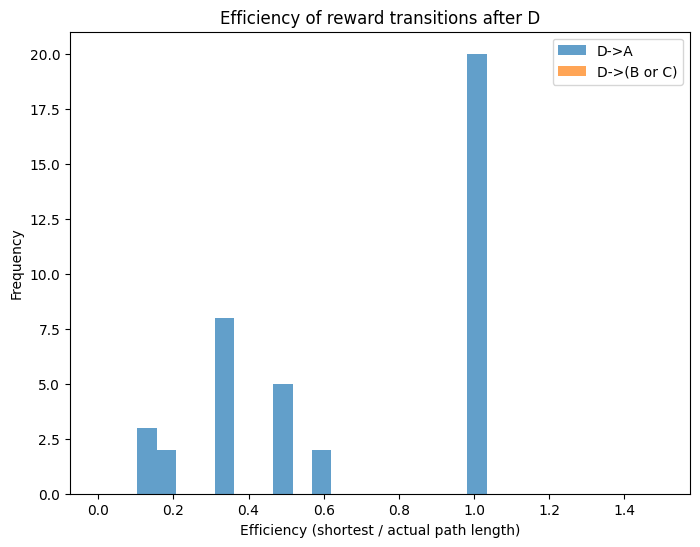


Proportion of D->A transitions: 1.00, chance level: 0.33
Sessions with D->A along the shortest path: 20
Sessions with a B->A or C->A transition via the shortest route in the first trial: 0


In [6]:
# We define a function to compute Manhattan distance between any two nodes in the 3x3 grid.
grid_positions = {
    0: (0, 0), 1: (0, 1), 2: (0, 2),
    3: (1, 0), 4: (1, 1), 5: (1, 2),
    6: (2, 0), 7: (2, 1), 8: (2, 2)
}

def manhattan_distance(n1, n2):
    r1, c1 = grid_positions[n1]
    r2, c2 = grid_positions[n2]
    return abs(r1 - r2) + abs(c1 - c2)

# For each test session, the corresponding test_task gives the reward locations for A, B, C, D
# (e.g., task = [loc_A, loc_B, loc_C, loc_D]).
# We'll look through each session and focus on the very first reward transition 
# where the reward collected is D. Then we check what reward is reached next.
# We also extract the actual path (using the sequence of visited locations) between the two reward events.
# We then compute the actual traveled distance and compare it to the theoretical shortest (Manhattan) distance.

d_to_A_actual = []
d_to_A_theoretical = []
other_to_A_actual = []  # when from D the next reward is B or C and then eventually A (if chosen)
other_to_A_theoretical = []
d_to_A_efficiencies = []
other_to_A_efficiencies = []
count_d_to_A = 0
count_other = 0

# Iterate over each test session (assuming test_sessions_data and test_tasks align in order)
for sess_idx, session in enumerate(test_sessions_data):
    # Get the reward locations for this session
    task = test_tasks[sess_idx]  # [reward_A, reward_B, reward_C, reward_D]
    reward_map = {'A': task[0], 'B': task[1], 'C': task[2], 'D': task[3]}

    # Identify indices where a reward event occurred (reward > 0 and a reward label available)
    reward_indices = [i for i, ev in enumerate(session) 
                      if ev.get('reward', 0) > 0 and ev.get('reward_label') is not None]
    # Skip session if there are fewer than 2 reward events.
    if len(reward_indices) < 2:
        continue


    # Look for the first transition starting with a D reward.
    for j in range(len(reward_indices) - 1):
        curr_ev = session[reward_indices[j]]
        next_ev = session[reward_indices[j+1]]
        if curr_ev['reward_label'] == 'D':
            start_label = 'D'
            next_label = next_ev['reward_label']
            # Extract the sequence of visited locations from the current reward until the next reward.
            path = [session[k]['location'] for k in range(reward_indices[j], reward_indices[j+1] + 1)]
            # Compute actual traveled path length (sum Manhattan distances between consecutive states)
            actual_length = sum(manhattan_distance(path[k], path[k+1]) for k in range(len(path)-1))
            # Theoretical shortest distance from the D location to the next reward location.
            # (reward_map gives the environment node for each reward label)
            theor_length = manhattan_distance(reward_map['D'], reward_map[next_label])
            efficiency = theor_length / actual_length if actual_length > 0 else np.nan

            if next_label == 'A':
                d_to_A_actual.append(actual_length)
                d_to_A_theoretical.append(theor_length)
                d_to_A_efficiencies.append(efficiency)
                count_d_to_A += 1
            elif next_label in ['B', 'C']:
                other_to_A_actual.append(actual_length)
                other_to_A_theoretical.append(theor_length)
                other_to_A_efficiencies.append(efficiency)
                count_other += 1
            break  # only consider the very first transition per session

print("Number of sessions with D->A transition:", count_d_to_A)
print("Number of sessions with D->(B or C) transition:", count_other)

# Let’s print average actual path lengths and efficiency ratios for the two groups.
if d_to_A_actual:
    print("\n[D->A] Mean actual path length: {:.2f}".format(np.mean(d_to_A_actual)))
    print("[D->A] Mean theoretical distance: {:.2f}".format(np.mean(d_to_A_theoretical)))
    print("[D->A] Mean efficiency (theoretical/actual): {:.2f}".format(np.mean(d_to_A_efficiencies)))
if other_to_A_actual:
    print("\n[D->(B or C)] Mean actual path length: {:.2f}".format(np.mean(other_to_A_actual)))
    print("[D->(B or C)] Mean theoretical distance: {:.2f}".format(np.mean(other_to_A_theoretical)))
    print("[D->(B or C)] Mean efficiency (theoretical/actual): {:.2f}".format(np.mean(other_to_A_efficiencies)))

# Optionally, plot the efficiencies to visualize the difference.
plt.figure(figsize=(8, 6))
bins = np.linspace(0, 1.5, 30)
plt.hist(d_to_A_efficiencies, bins=bins, alpha=0.7, label='D->A')
plt.hist(other_to_A_efficiencies, bins=bins, alpha=0.7, label='D->(B or C)')
plt.xlabel('Efficiency (shortest / actual path length)')
plt.ylabel('Frequency')
plt.title('Efficiency of reward transitions after D')
plt.legend()
plt.show()

# Additionally, we can compute efficiency ratios for early returns:
# cases where after a D reward event the next reward is B or C,
# and then the very next reward is A.
dA_early_actual = []
dA_early_theoretical = []
dA_early_efficiencies = []

# Iterate over each test session.
for sess_idx, session in enumerate(test_sessions_data):
    # Get the reward locations for this session.
    task = test_tasks[sess_idx]  # [reward_A, reward_B, reward_C, reward_D]
    reward_map = {'A': task[0], 'B': task[1], 'C': task[2], 'D': task[3]}
    
    # Identify indices where a reward event occurred.
    reward_indices = [i for i, ev in enumerate(session) 
                      if ev.get('reward', 0) > 0 and ev.get('reward_label') is not None]
    # We need at least three reward events: D, then B/C, then A.
    if len(reward_indices) < 3:
        continue
    
    # Look for a transition starting with a D reward, followed by B or C,
    # and then the next available A.
    for j in range(len(reward_indices) - 2):
        curr_ev = session[reward_indices[j]]
        mid_ev = session[reward_indices[j+1]]
        if curr_ev['reward_label'] == 'D' and mid_ev['reward_label'] in ['B', 'C']:
            # Search for the next A reward event.
            for k in range(j+2, len(reward_indices)):
                nextA_ev = session[reward_indices[k]]
                if nextA_ev['reward_label'] == 'A':
                    # Extract the visited locations from D (curr_ev) to A.
                    path = [session[m]['location'] for m in range(reward_indices[j], reward_indices[k]+1)]
                    actual_length = sum(manhattan_distance(path[idx], path[idx+1]) for idx in range(len(path)-1))
                    # Theoretical shortest distance is from the B/C location (mid_ev) to A.
                    theor_length = manhattan_distance(reward_map[mid_ev['reward_label']], reward_map['A'])
                    efficiency = theor_length / actual_length if actual_length > 0 else np.nan
                    dA_early_actual.append(actual_length)
                    dA_early_theoretical.append(theor_length)
                    dA_early_efficiencies.append(efficiency)
                    break  # consider only the first A after the B/C event.
            break  # only consider the very first transition per session.

if dA_early_actual:
    print("\n[Early Return: B/C->A] Mean actual path length: {:.2f}".format(np.mean(dA_early_actual)))
    print("[Early Return: B/C->A] Mean theoretical distance: {:.2f}".format(np.mean(dA_early_theoretical)))
    print("[Early Return: B/C->A] Mean efficiency (theoretical/actual): {:.2f}".format(np.mean(dA_early_efficiencies)))
# ion of D->A transitions.
total = count_d_to_A + count_other
if total > 0:
    proportion = count_d_to_A / total
    chance = 1/3  # if choices are uniformly distributed among A, B and C
    print("\nProportion of D->A transitions: {:.2f}, chance level: {:.2f}".format(proportion, chance))


import numpy as np

# Count sessions where efficiency is exactly 1 (or nearly 1)
shortest_DA = np.sum(np.isclose(np.array(d_to_A_efficiencies), 1.0))
print("Sessions with D->A along the shortest path:", shortest_DA)
# Count sessions where the very first transition starting after a B or C reward reaches location A
# via the shortest route (i.e. the path length equals the Manhattan distance between the B/C reward location and reward A location).
count_BC_A_shortest = 0

for sess_idx, session in enumerate(test_sessions_data):
    # Get task and reward mapping for the session.
    task = test_tasks[sess_idx]  # [reward_A, reward_B, reward_C, reward_D]
    reward_mapping = {'A': task[0], 'B': task[1], 'C': task[2], 'D': task[3]}
    
    # Identify indices where a reward event occurred.
    indices = [i for i, ev in enumerate(session) if ev.get('reward', 0) > 0 and ev.get('reward_label') is not None]
    if not indices:
        continue

    # Look for the first reward event from either B or C.
    found = False
    for j in indices:
        current_ev = session[j]
        if current_ev['reward_label'] in ['B', 'C']:
            # Set the target location for A from the task mapping.
            target_location = reward_mapping['A']
            # Look for the first occurrence in the session (after the current event) where the current location equals target.
            for k in range(j + 1, len(session)):
                if session[k]['location'] == target_location:
                    # Extract the route from the B/C rewarded event to when location A is reached.
                    route = [session[m]['location'] for m in range(j, k + 1)]
                    actual_distance = sum(manhattan_distance(route[m], route[m + 1]) for m in range(len(route) - 1))
                    theoretical_distance = manhattan_distance(reward_mapping[current_ev['reward_label']], target_location)
                    efficiency = theoretical_distance / actual_distance if actual_distance > 0 else np.nan
                    if np.isclose(efficiency, 1.0):
                        count_BC_A_shortest += 1
                    found = True
                    break
            if found:
                break

print("Sessions with a B->A or C->A transition via the shortest route in the first trial:", count_BC_A_shortest)

In [7]:
# We define a function to compute Manhattan distance between any two nodes in the 3x3 grid.
grid_positions = {
    0: (0, 0), 1: (0, 1), 2: (0, 2),
    3: (1, 0), 4: (1, 1), 5: (1, 2),
    6: (2, 0), 7: (2, 1), 8: (2, 2)
}

def manhattan_distance(n1, n2):
    r1, c1 = grid_positions[n1]
    r2, c2 = grid_positions[n2]
    return abs(r1 - r2) + abs(c1 - c2)

zero_shots = []
b_zero_shots = []
c_zero_shots = []

for session, task in zip(test_sessions_data, test_tasks):
    # Get the reward locations for this session
    reward_map = {'A': task[0], 'B': task[1], 'C': task[2], 'D': task[3]}
    # Convert the list of dictionaries (timepoints) to a dataframe
    df = pd.DataFrame(session)

    first_A = df[df['reward_label'] =='A'].index[0] 
    first_B = df[df['reward_label'] =='B'].index[0]
    first_C = df[df['reward_label'] =='C'].index[0]

    A_all = df[df['reward_label'] == 'A'].index

    b_transition_theoretical = manhattan_distance(reward_map['B'], reward_map['A'])
    c_transition_theoretical = manhattan_distance(reward_map['C'], reward_map['A'])

    visited_A_indices = df[df['location'] == reward_map['A']].index

    print(f'first_A: {first_A}, first_B: {first_B}, first_C: {first_C}')
    print(f'visited_A_indices: {visited_A_indices}')
    first_A_after_B = next((idx for idx in visited_A_indices if idx > first_B), None)
    b_transition_actual = first_A_after_B-1 - first_B
    

    first_A_after_C = next((idx for idx in visited_A_indices if idx > first_C), None)
    c_transition_actual = first_A_after_C-1 - first_C

    c_zero_shot = c_transition_actual == c_transition_theoretical
    b_zero_shot = b_transition_actual == b_transition_theoretical

    c_zero_shots.append(c_zero_shot)
    b_zero_shots.append(b_zero_shot)

    df[df['reward_label'] == 'B'].index[0] if len(A_all) > 0 else None
    # Identify indices where a reward event occurred (reward > 0 and a reward label available)
    first_D = df[df['reward_label'] == 'D'].index[0]
    second_A = df[df['reward_label']=='A'].index[1]
    path_length_actual = second_A - first_D
    path_length_theoretical = manhattan_distance(reward_map['D'], reward_map['A'])
    zero_shot = path_length_actual == path_length_theoretical
    zero_shots.append(zero_shot)

print(f'{sum(zero_shots)} session out of {len(zero_shots)} had a zero shot')
print(f'{sum(b_zero_shots)} sessions out of {len(b_zero_shots)} had early termination B')
print(f'{sum(c_zero_shots)} sessions out of {len(c_zero_shots)} had early termination for C')






first_A: 0, first_B: 3, first_C: 7
visited_A_indices: Index([  1,   7,  11,  17,  25,  41,  53,  65,  77,  91, 103, 115, 131, 145,
       155, 161, 167, 175, 191],
      dtype='int64')
first_A: 5, first_B: 9, first_C: 16
visited_A_indices: Index([  6,  14,  20,  28,  34,  46,  58,  70,  82,  94, 104, 114, 126, 138,
       150, 162, 174, 186, 198],
      dtype='int64')
first_A: 7, first_B: 9, first_C: 11
visited_A_indices: Index([  0,   8,  16,  22,  30,  36,  44,  50,  73,  87, 109, 129, 137, 143,
       159, 167, 177, 187, 197],
      dtype='int64')
first_A: 6, first_B: 12, first_C: 19
visited_A_indices: Index([  7,  15,  25,  33,  39,  43,  47,  51,  55,  61,  65,  67,  71,  75,
        77,  81,  85,  87,  91,  95,  97, 101, 105, 107, 111, 115, 117, 121,
       125, 127, 131, 133, 137, 139, 143, 147, 153, 157, 161, 165, 169, 173,
       177, 181, 183, 189, 195, 199],
      dtype='int64')
first_A: 2, first_B: 8, first_C: 11
visited_A_indices: Index([3, 15, 23, 41, 60, 75, 90, 102, 117

In [8]:
for sess_idx, session in enumerate(test_sessions_data):
    # Get the task mapping for this session.
    task = test_tasks[sess_idx]  # e.g., [reward_A, reward_B, reward_C, reward_D]
    reward_map = {'A': task[0], 'B': task[1], 'C': task[2], 'D': task[3]}
    
    # Identify indices where a reward event occurred.
    reward_indices = [i for i, ev in enumerate(session)
                      if ev.get('reward', 0) > 0 and ev.get('reward_label') is not None]
    
    if len(reward_indices) < 2:
        continue

    transition_counts = {}
    shortest_counts = {}
    
    # Loop through consecutive reward transitions in the current session
    for j in range(len(reward_indices) - 1):
        curr_label = session[reward_indices[j]]['reward_label']
        next_label = session[reward_indices[j+1]]['reward_label']
        pair = (curr_label, next_label)
    
        transition_counts[pair] = transition_counts.get(pair, 0) + 1
        
        # Get the path of locations from current to next reward event.
        path = [session[k]['location'] for k in range(reward_indices[j], reward_indices[j+1] + 1)]
        actual_length = sum(manhattan_distance(path[m], path[m+1]) for m in range(len(path) - 1))
        theoretical_length = manhattan_distance(reward_map[curr_label], reward_map[next_label])
        
        if actual_length == theoretical_length:
            shortest_counts[pair] = shortest_counts.get(pair, 0) + 1

    print(f"Session {sess_idx} {task}:")
    for (start, end), count in transition_counts.items():
        fraction = shortest_counts.get((start, end), 0) / count
        print("   Fraction of {}->{} transitions along the shortest route: {:.2f}".format(start, end, fraction))


Session 0 [5, 6, 4, 0]:
   Fraction of A->B transitions along the shortest route: 0.92
   Fraction of B->C transitions along the shortest route: 0.85
   Fraction of C->D transitions along the shortest route: 0.58
   Fraction of D->A transitions along the shortest route: 0.00
Session 1 [6, 2, 5, 3]:
   Fraction of A->B transitions along the shortest route: 1.00
   Fraction of B->C transitions along the shortest route: 0.00
   Fraction of C->D transitions along the shortest route: 1.00
   Fraction of D->A transitions along the shortest route: 1.00
Session 2 [8, 2, 0, 1]:
   Fraction of A->B transitions along the shortest route: 0.91
   Fraction of B->C transitions along the shortest route: 1.00
   Fraction of C->D transitions along the shortest route: 0.00
   Fraction of D->A transitions along the shortest route: 0.40
Session 3 [7, 3, 4, 5]:
   Fraction of A->B transitions along the shortest route: 0.73
   Fraction of B->C transitions along the shortest route: 0.00
   Fraction of C->D tr

In [ ]:
# Compute PCA over concatenated reward profiles from all sessions.
global_X = []

# Loop over each session
for session_id in range(len(dataframes)):
    # For each session, stack reward-profile rows for all units: shape (4, num_units)
    session_data = np.vstack([hm[session_id, :] for hm in heatmaps.values()])
    X_session = session_data.T  # Each row corresponds to a reward label
    global_X.append(X_session)

# Concatenate these matrices along the rows: shape (num_sessions*4, num_units)
global_X = np.vstack(global_X)

# Run PCA
pca_global = PCA(n_components=3)
X_global_pca = pca_global.fit_transform(global_X)

# Plot the PCA projection: each block of 4 rows corresponds to a session.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
cmap_list = [plt.cm.viridis, plt.cm.plasma, plt.cm.inferno, plt.cm.magma, plt.cm.cividis]
reward_labels = ['A', 'B', 'C', 'D']

for session_id in range(5):
    # Extract the 4 reward entries for the current session.
    X_session_pca = X_global_pca[session_id*4:(session_id*4 + 4), :]
    color = cmap_list[session_id](0.6)
    ax.scatter(X_session_pca[:, 0], X_session_pca[:, 1], X_session_pca[:, 2],
               s=100, color=color, label=f'Session {session_id+1}')
    # Annotate the points with reward labels.
    for i, (x, y, z) in enumerate(X_session_pca):
        ax.text(x, y, z, reward_labels[i], fontsize=12, color=color)
    # Connect the points in order A-B-C-D-A.
    indices = [0, 1, 2, 3, 0]
    pts = X_session_pca[indices, :]
    ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], color=color, lw=2, alpha=0.7)

ax.set_title("Global PCA on Concatenated State heatmaps")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()


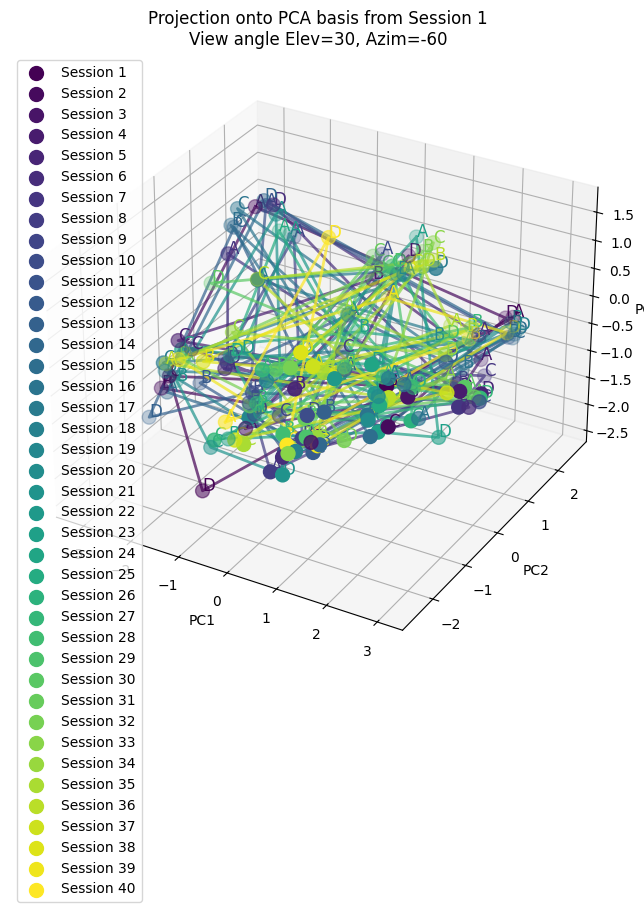

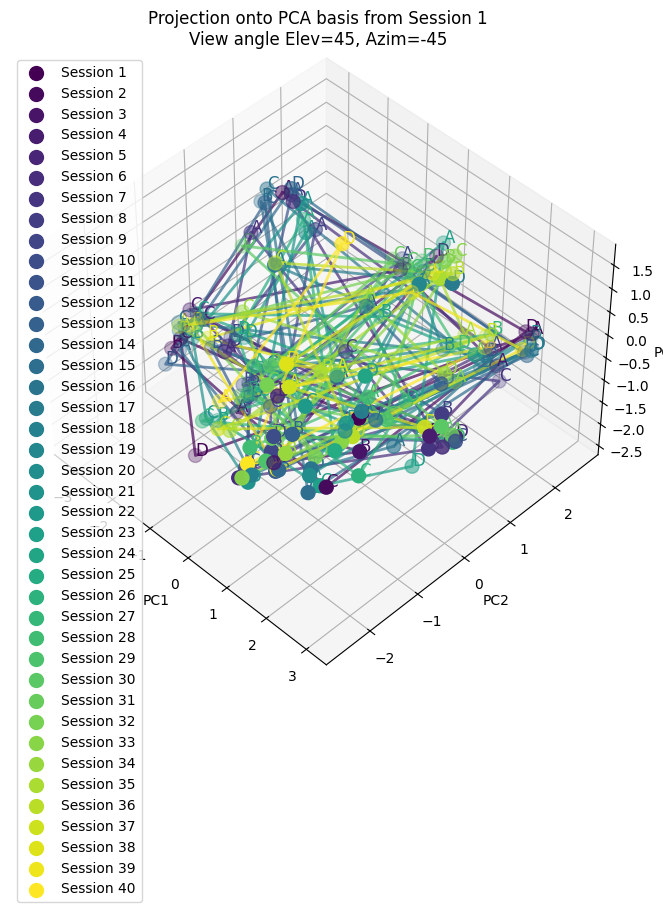

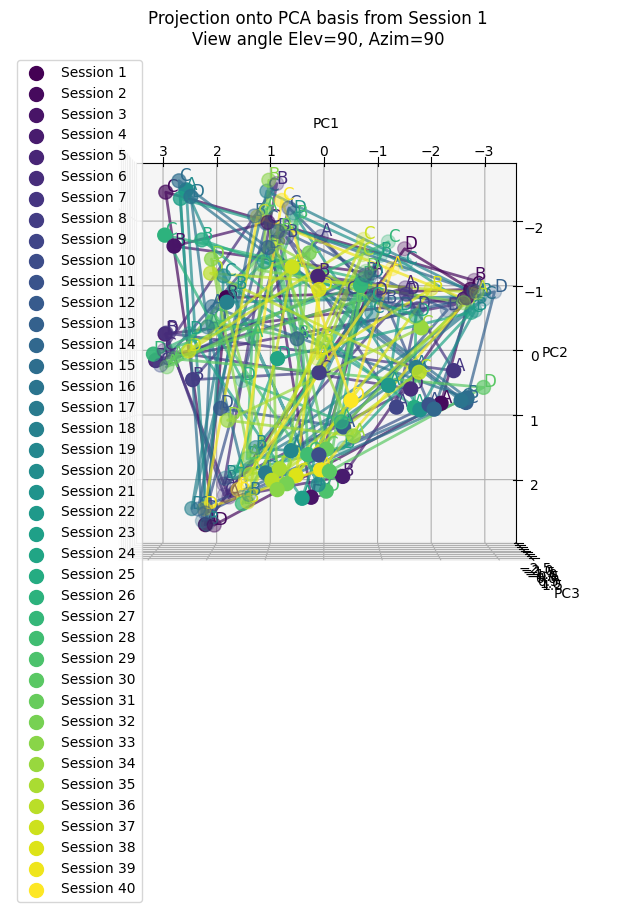

In [ ]:
# Choose session 1 (index 1) to compute PCA basis.
session_number = 1  # change this if you meant a different session
view_angles = [(30, -60), (45, -45), (90, 90)]  #
# Build the data matrix for session 1.
session1_data = np.vstack([hm[session_number, :] for hm in heatmaps.values()])  # shape (#units, 4)
X_session1 = session1_data.T  # shape (4, #units); each row is a reward label

# Run PCA on session 1 data to get the basis vectors.
pca_session1 = PCA(n_components=3)
X_session1_pca = pca_session1.fit_transform(X_session1)  # shape (4,3)

# Now project all sessions' data onto the PCA basis computed from session 1,
# and visualize with a bunch of view angles.
for elev, azim in view_angles:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a color map, one color per session.
    colors = plt.cm.viridis(np.linspace(0, 1, len(dataframes)))
    
    for sess_id, df in enumerate(dataframes):
        # Build the data matrix for current session.
        session_data = np.vstack([hm[sess_id, :] for hm in heatmaps.values()])  # shape (#units, 4)
        X_session = session_data.T  # shape (4, #units)
        # Use the PCA computed from session1 to project current session.
        X_proj = pca_session1.transform(X_session)  # shape (4, 3)
        color = colors[sess_id]
        ax.scatter(X_proj[:, 0], X_proj[:, 1], X_proj[:, 2], s=100, color=color, label=f'Session {sess_id+1}')
        # Annotate points using the reward labels.
        for i, (x, y, z) in enumerate(X_proj):
            ax.text(x, y, z, reward_labels[i], fontsize=12, color=color)
        # Connect the rewards in order A-B-C-D-A.
        indices = [0, 1, 2, 3, 0]
        pts = X_proj[indices, :]
        ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], color=color, lw=2, alpha=0.7)
    
    ax.set_title(f"Projection onto PCA basis from Session 1\nView angle Elev={elev}, Azim={azim}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.legend()
    ax.view_init(elev=elev, azim=azim)
    plt.show()

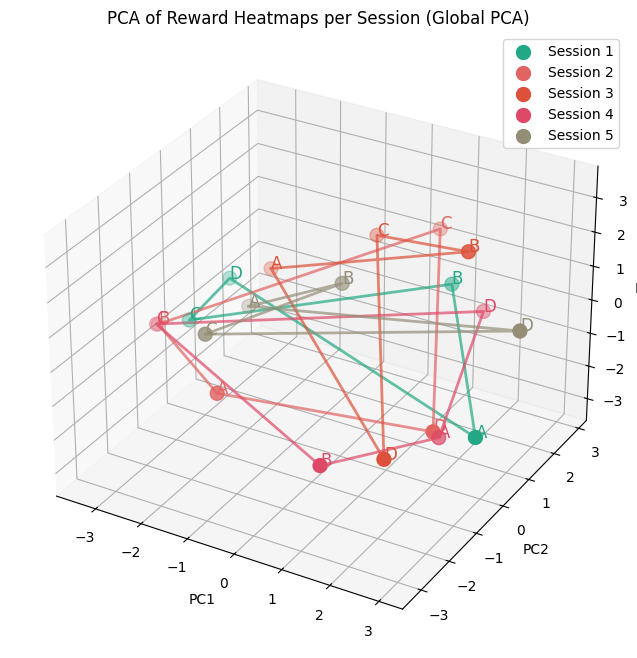

In [ ]:
# Compute global PCA over reward profiles from all sessions.
# For each session, construct a 4 x (#units) matrix (each row = reward label profile).
global_X = []
for session_id in range(5):
    session_data = np.vstack([hm[session_id, :] for hm in heatmaps.values()])  # shape: (#units, 4)
    X_session = session_data.T  # shape: (4, #units); one row per reward label
    global_X.append(X_session)
global_X = np.vstack(global_X)  # shape: (5*4, #units)

# Run PCA on the combined data.
pca_global = PCA(n_components=3)
X_global_pca = pca_global.fit_transform(global_X)  # shape: (20, 3)

# Plot the projection for each session separately, using the same 
# connection pattern (A-B, B-C, C-D, D-A) as above.
cmap_list = [plt.cm.viridis, plt.cm.plasma, plt.cm.inferno, plt.cm.magma, plt.cm.cividis]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for session_id in range(5):
    # For session_id, the 4 rows in X_global_pca correspond to reward labels A, B, C, D
    X_session_pca = X_global_pca[session_id*4:(session_id*4 + 4), :]
    
    color = cmap_list[session_id](0.6)
    
    # Scatter the 4 projected points.
    ax.scatter(X_session_pca[:, 0], X_session_pca[:, 1], X_session_pca[:, 2],
               s=100, color=color, label=f'Session {session_id+1}')
    
    # Annotate with reward labels.
    for i, (x, y, z) in enumerate(X_session_pca):
        ax.text(x, y, z, reward_labels[i], fontsize=12, color=color)
    
    # Connect the rewards in the order A, B, C, D and back to A.
    indices = [0, 1, 2, 3, 0]
    pts = X_session_pca[indices, :]
    ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], color=color, lw=2, alpha=0.7)

ax.set_title("PCA of Reward Heatmaps per Session (Global PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()

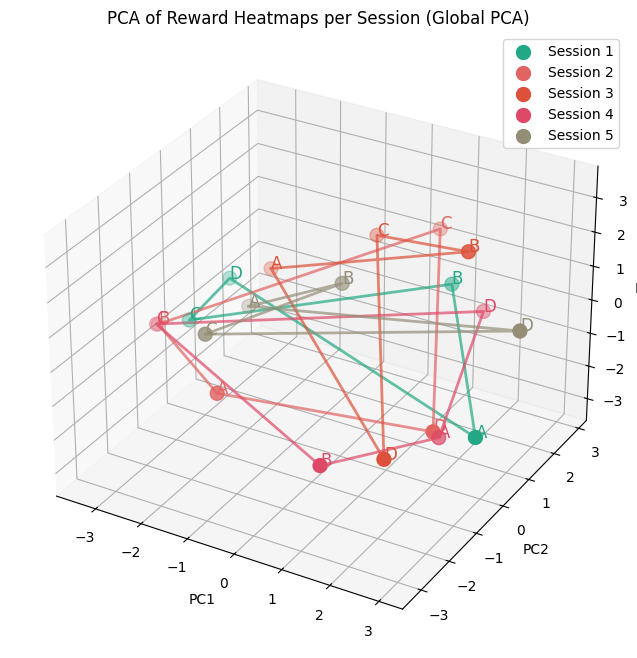

In [ ]:
# Compute global PCA over reward profiles from all sessions.
# For each session, construct a 4 x (#units) matrix (each row = reward label profile).
global_X = []
for session_id in range(5):
    session_data = np.vstack([hm[session_id, :] for hm in heatmaps.values()])  # shape: (#units, 4)
    X_session = session_data.T  # shape: (4, #units); one row per reward label
    global_X.append(X_session)
global_X = np.vstack(global_X)  # shape: (5*4, #units)

# Run PCA on the combined data.
pca_global = PCA(n_components=3)
X_global_pca = pca_global.fit_transform(global_X)  # shape: (20, 3)

# Plot the projection for each session separately, using the same 
# connection pattern (A-B, B-C, C-D, D-A) as above.
cmap_list = [plt.cm.viridis, plt.cm.plasma, plt.cm.inferno, plt.cm.magma, plt.cm.cividis]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for session_id in range(5):
    # For session_id, the 4 rows in X_global_pca correspond to reward labels A, B, C, D
    X_session_pca = X_global_pca[session_id*4:(session_id*4 + 4), :]
    
    color = cmap_list[session_id](0.6)
    
    # Scatter the 4 projected points.
    ax.scatter(X_session_pca[:, 0], X_session_pca[:, 1], X_session_pca[:, 2],
               s=100, color=color, label=f'Session {session_id+1}')
    
    # Annotate with reward labels.
    for i, (x, y, z) in enumerate(X_session_pca):
        ax.text(x, y, z, reward_labels[i], fontsize=12, color=color)
    
    # Connect the rewards in the order A, B, C, D and back to A.
    indices = [0, 1, 2, 3, 0]
    pts = X_session_pca[indices, :]
    ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], color=color, lw=2, alpha=0.7)

ax.set_title("PCA of Reward Heatmaps per Session (Global PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()

In [ ]:
# Initialize a dictionary to store the heatmaps for each unit
location_heatmaps = {}

# Iterate through each unit in the activation
for unit in range(len(dataframes[0]['activation'][0])):
    # Initialize a 5x9 matrix to store the average activations (5 sessions x 9 locations)
    avg_activations = np.zeros((len(dataframes), 9))
    
    # Iterate through each session (dataframe)
    for i, df in enumerate(dataframes):
        # Filter the dataframe by location
        for j in range(9):
            # Get the activations for the current unit where the location is the current location
            activations = df[df['location'] == j]['activation'].apply(lambda x: x[unit])
            # Calculate the average activation and store it in the matrix
            if not activations.empty:
                avg_activations[i, j] = activations.mean()
    
    # Create a heatmap for the current unit
    # plt.figure(figsize=(10, 6))
    # sns.heatmap(avg_activations, annot=True, xticklabels=[f'Location {j}' for j in range(9)], yticklabels=[f'Session {i+1}' for i in range(5)])
    # plt.title(f'Heatmap for Unit {unit} by Location')
    # plt.xlabel('Location')
    # plt.ylabel('Session')
    # plt.show()
    
    # Store the heatmap in the dictionary
    location_heatmaps[unit] = avg_activations

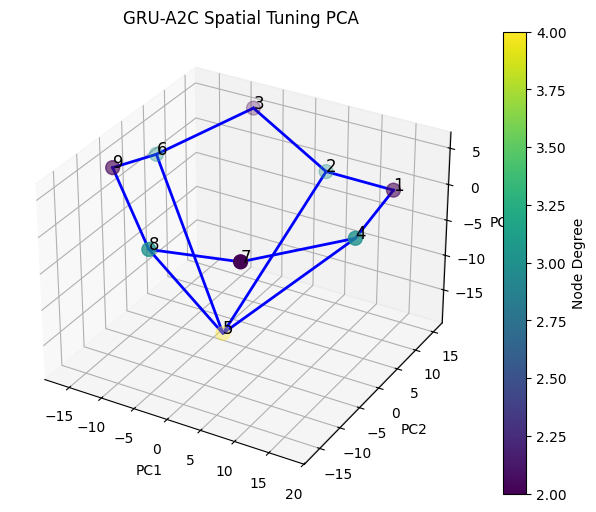

In [ ]:
from sklearn.decomposition import PCA

# Step 1: Concatenate the spatial tuning responses for all neurons and sessions.
all_responses = np.concatenate(list(location_heatmaps.values()), axis=0)

# Step 2: For a population representation of each spatial location, we want one 9-dimensional vector per location.
X = all_responses.T  # shape: (9, num_neurons * num_sessions)

# Step 3: Run PCA on the 9 observations (each is a "population vector" for one location)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)  # shape: (9, 3)

# Step 4: Plot the 9 points in 3D and connect them as in a 3x3 maze.
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Define node degrees for coloring (using degrees for a 3x3 grid)
node_degrees = {0: 2, 1: 3, 2: 2,
                3: 3, 4: 4, 5: 3,
                6: 2, 7: 3, 8: 2}
degrees = np.array([node_degrees[i] for i in range(9)])

# Use node degrees for coloring (node_degrees and degrees are defined in a later cell)
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], s=100, c=degrees, cmap='viridis')
plt.colorbar(scatter, ax=ax, label='Node Degree')
for loc_idx, (x, y, z) in enumerate(X_pca):
    ax.text(x, y, z, str(loc_idx+1), fontsize=12)

# Define maze connectivity by rows and columns.
maze_rows = [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
maze_cols = [[0, 3, 6], [1, 4, 7], [2, 5, 8]]

# Draw horizontal (row) and vertical (column) connections.
for row in maze_rows:
    ax.plot(X_pca[row, 0], X_pca[row, 1], X_pca[row, 2], color='blue', lw=2)
for col in maze_cols:
    ax.plot(X_pca[col, 0], X_pca[col, 1], X_pca[col, 2], color='blue', lw=2)

ax.set_title("GRU-A2C Spatial Tuning PCA")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()


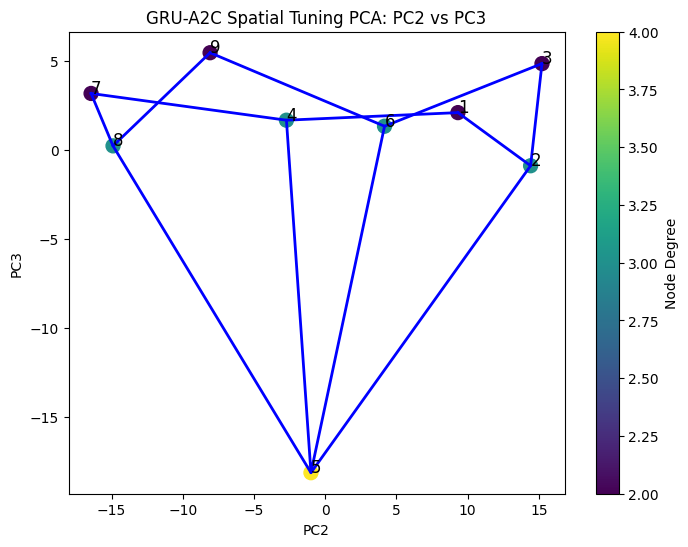

In [ ]:
from sklearn.decomposition import PCA

# Step 1: Concatenate the spatial tuning responses for all neurons and sessions.
all_responses = np.concatenate(list(location_heatmaps.values()), axis=0)

# Step 2: For a population representation of each spatial location,
# we want one 9-dimensional vector per location.
X = all_responses.T  # shape: (9, num_neurons * num_sessions)X = all_responses.T  # shape: (9, num_neurons * num_sessions)X = all_responses.T  # shape: (9, num_neurons * num_sessions)X = all_responses.T  # shape: (9, num_neurons * num_sessions)

# Step 3: Run PCA on the 9 observations (each is a "population vector" for one location)9 observations (each is a "population vector" for one location)9 observations (each is a "population vector" for one location)9 observations (each is a "population vector" for one location)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)  # shape: (9, 3)X_pca = pca.fit_transform(X)  # shape: (9, 3)X_pca = pca.fit_transform(X)  # shape: (9, 3)X_pca = pca.fit_transform(X)  # shape: (9, 3)

# Step 4: Plot PC2 and PC3 with maze connectivity.maze connectivity.maze connectivity.maze connectivity.
fig, ax = plt.subplots(figsize=(8, 6))

# Define node degrees for coloringng
node_degrees = {0: 2, 1: 3, 2: 2,
                3: 3, 4: 4, 5: 3,
                6: 2, 7: 3, 8: 2}
degrees = np.array([node_degrees[i] for i in range(9)])

# Scatter plot on PC2 (x) and PC3 (y)
scatter = ax.scatter(X_pca[:, 1], X_pca[:, 2], s=100, c=degrees, cmap='viridis')
plt.colorbar(scatter, ax=ax, label='Node Degree')

# Annotate points
for loc_idx, (pc2, pc3) in enumerate(zip(X_pca[:, 1], X_pca[:, 2])):
    ax.text(pc2, pc3, str(loc_idx+1), fontsize=12)

# Define maze connectivity (rows and columns of a 3x3 grid)of a 3x3 grid)of a 3x3 grid)of a 3x3 grid)
maze_rows = [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
maze_cols = [[0, 3, 6], [1, 4, 7], [2, 5, 8]]

# Draw horizontal (row) and vertical (column) connections.
for row in maze_rows:
    ax.plot(X_pca[row, 1], X_pca[row, 2], color='blue', lw=2)
for col in maze_cols:
    ax.plot(X_pca[col, 1], X_pca[col, 2], color='blue', lw=2)

ax.set_title("GRU-A2C Spatial Tuning PCA: PC2 vs PC3")
ax.set_xlabel("PC2")
ax.set_ylabel("PC3")
plt.show()



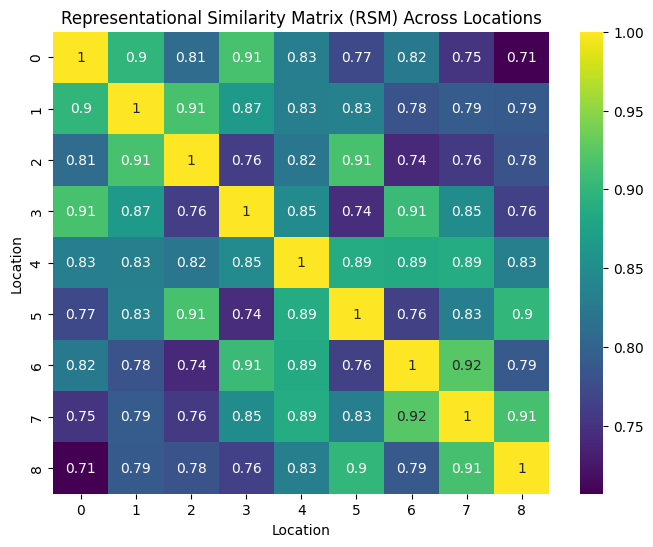

In [ ]:
from scipy.spatial.distance import pdist, squareform

# Compute representational similarity matrix (RSM) across locations for session 1
# Each location's population activity is the mean activation vector for that location

# Get unique locations in session1_df
unique_locations = session1_df['location'].unique()
unique_locations.sort()

# For each location, compute the mean activation vector (population activity)
location_vectors = []
for loc in unique_locations:
    activations = np.stack(session1_df[session1_df['location'] == loc]['activation'].values)
    mean_vector = activations.mean(axis=0)
    location_vectors.append(mean_vector)
location_vectors = np.stack(location_vectors)  # shape: (num_locations, num_units)

# Compute the representational similarity matrix (correlation between location vectors)

# Use correlation distance, then convert to similarity (1 - distance)
corr_dist = pdist(location_vectors, metric='correlation')
rsm = 1 - squareform(corr_dist)  # shape: (num_locations, num_locations)

# Plot the RSM
plt.figure(figsize=(8, 6))
sns.heatmap(rsm, annot=True, cmap='viridis', xticklabels=unique_locations, yticklabels=unique_locations)
plt.title('Representational Similarity Matrix (RSM) Across Locations')
plt.xlabel('Location')
plt.ylabel('Location')
plt.show()

In [ ]:
rsm.shape

(9, 9)

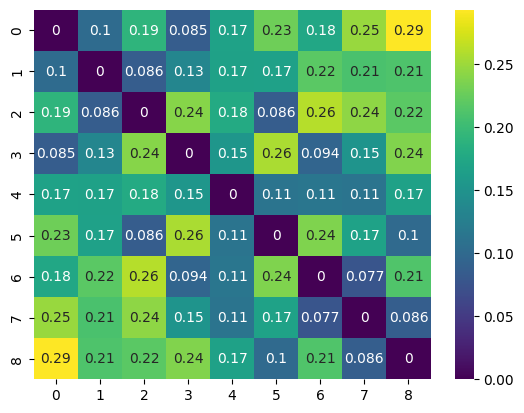

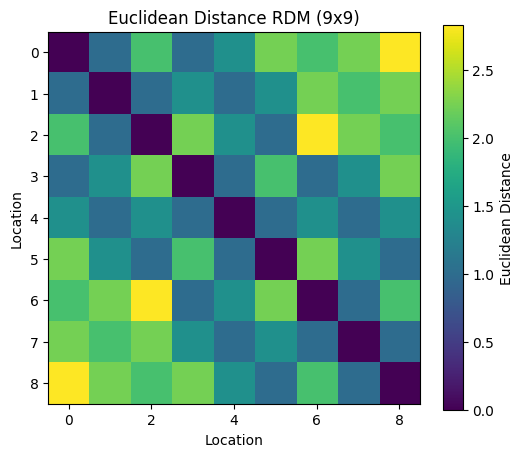

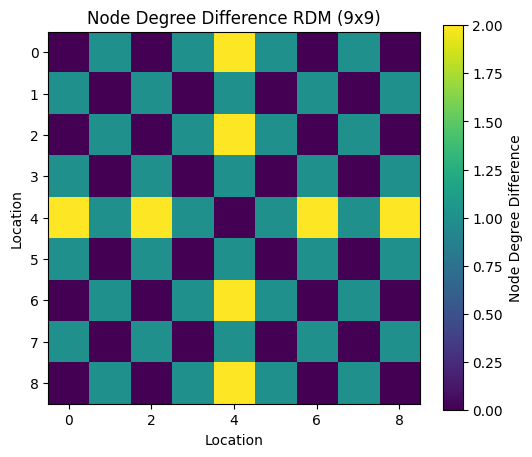

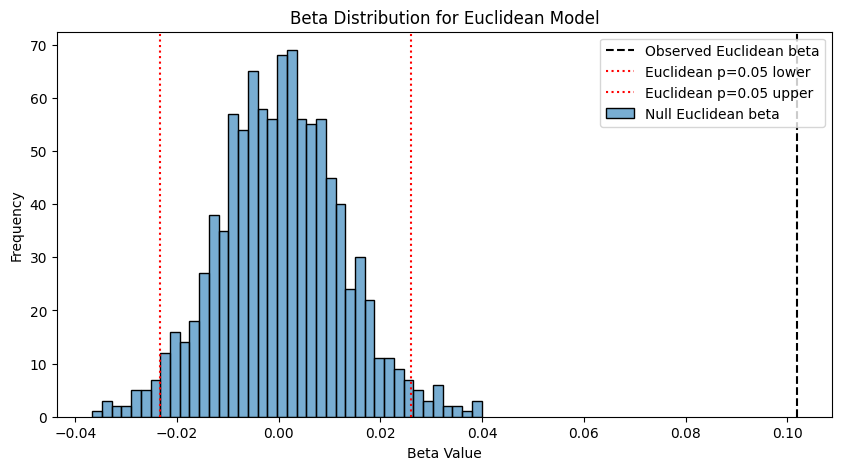

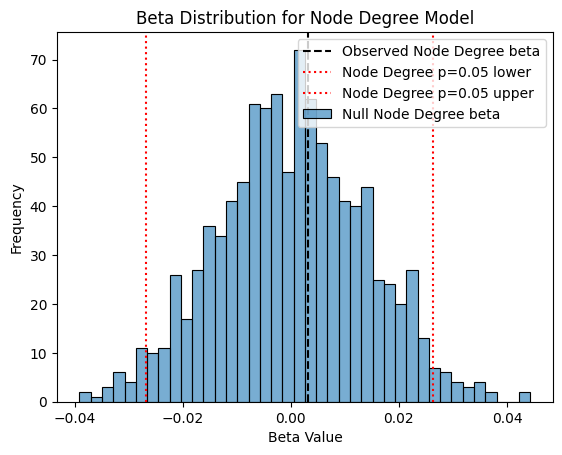

In [ ]:
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

data_rdm = 1-rsm
sns.heatmap(data_rdm, annot=True, cmap='viridis', xticklabels=unique_locations, yticklabels=unique_locations)
# # 1. Compute the data RDM (correlation distance between location vectors)
# location_vectors = []
# for loc in unique_locations:
#     activations = np.stack(session1_df[session1_df['location'] == loc]['activation'].values)
#     mean_vector = activations.mean(axis=0)
#     location_vectors.append(mean_vector)
# location_vectors = np.stack(location_vectors)  # shape: (num_locations, num_units)


# 2. Compute model RDMs
# Euclidean distance model
coords = np.array([divmod(loc, 3) for loc in unique_locations])  # 3x3 grid positions
euclid_rdm = pdist(coords, metric='euclidean')
# Compute full 9x9 Euclidean distance matrix for all pairs of locations on the 3x3 grid
euclid_rdm_matrix = squareform(euclid_rdm)
plt.figure(figsize=(6, 5))
plt.imshow(euclid_rdm_matrix, cmap='viridis', vmin=0, vmax=np.max(euclid_rdm_matrix))
plt.colorbar(label='Euclidean Distance')
plt.title('Euclidean Distance RDM (9x9)')
plt.xlabel('Location')
plt.ylabel('Location')
plt.show()
# plt.matshow(euclid_rdm.reshape(3, 3), cmap='viridis', vmin=0, vmax=np.max(euclid_rdm))
# Node degree model
# degrees = np.array([node_degrees[loc] for loc in unique_locations])
# degree_rdm = pdist(degrees.reshape(-1, 1), metric='euclidean')
# Node degree model RDM: absolute difference in node degree for each location pair
degrees = np.array([node_degrees[loc] for loc in unique_locations])
degree_rdm_matrix = np.abs(degrees[:, None] - degrees[None, :])  # shape (9, 9)
# degree_rdm = pdist(degrees.reshape(-1, 1), metric='cityblock')  # condensed form for regression

plt.figure(figsize=(6, 5))
plt.imshow(degree_rdm_matrix, cmap='viridis', vmin=0, vmax=np.max(degree_rdm_matrix))
plt.colorbar(label='Node Degree Difference')
plt.title('Node Degree Difference RDM (9x9)')
plt.xlabel('Location')
plt.ylabel('Location')
plt.show()
# plt.matshow(degree_rdm.reshape(3, 3), cmap='viridis', vmin=0, vmax=np.max(degree_rdm))

# 3. Linear regression: regress model RDMs onto data RDM
X = np.vstack([euclid_rdm_matrix.flatten(), degree_rdm_matrix.flatten()]).T
y = data_rdm.flatten()
reg = LinearRegression().fit(X, y)
betas = reg.coef_

# 4. Null distribution: shuffle rows of data_rdm 1000 times
null_betas = []
for _ in range(1000):
    shuffled_y = np.random.permutation(y)
    reg_null = LinearRegression().fit(X, shuffled_y)
    null_betas.append(reg_null.coef_)
null_betas = np.array(null_betas)

# 5. Plot betas distribution and p=0.05 line
plt.figure(figsize=(10, 5))
for i, label in enumerate(['Euclidean', 'Node Degree']):
    sns.histplot(null_betas[:, i], bins=40, alpha=0.6, label=f'Null {label} beta')
    plt.axvline(betas[i], color='k', linestyle='--', label=f'Observed {label} beta')
    # p=0.05 line (two-sided)
    lower = np.percentile(null_betas[:, i], 2.5)
    upper = np.percentile(null_betas[:, i], 97.5)
    plt.axvline(lower, color='r', linestyle=':', label=f'{label} p=0.05 lower')
    plt.axvline(upper, color='r', linestyle=':', label=f'{label} p=0.05 upper')
    plt.title(f'Beta Distribution for {label} Model')
    plt.xlabel('Beta Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [ ]:
betas.shape

(9, 18)

In [33]:
X.shape

(9, 18)

In [34]:
y.shape

(36,)

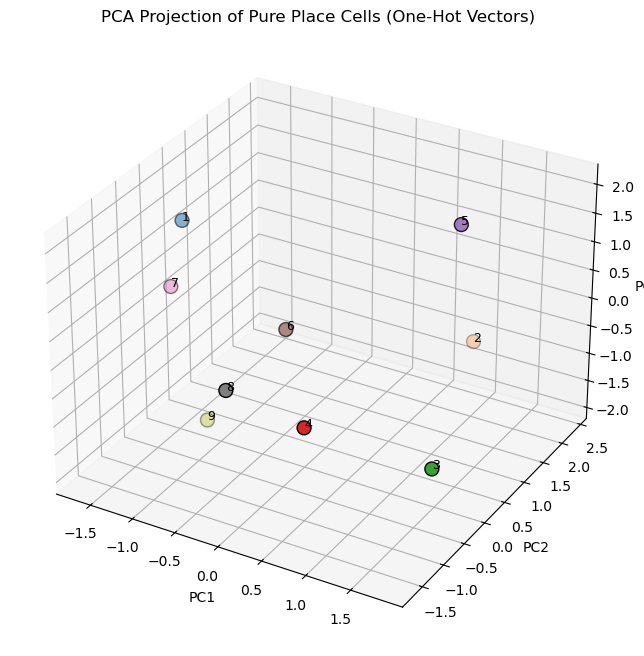

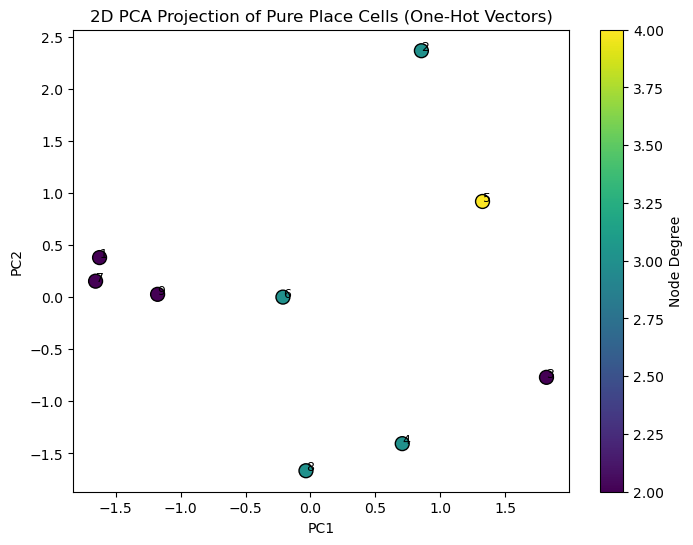

In [44]:
# Create multiple copies per location: 10 for each, except location 4 which gets 20
node_degrees = {0: 2, 1: 3, 2: 2,
                3: 3, 4: 4, 5: 3,
                6: 2, 7: 3, 8: 2}
pure_place_data = []
for loc in range(9):  # locations 0 to 8
    vec = np.zeros(9)
    vec[loc] = 1
    if loc==1:
        repeats= 10
    else:
        repeats = 7
    for _ in range(repeats):
        pure_place_data.append(vec)
pure_place_data = np.array(pure_place_data)
pure_place_data = pure_place_data + 0.2 * np.random.randn(*pure_place_data.shape)

# Run PCA on the pure place cell data using PCA from sklearn
pca_place = PCA(n_components=3)
pure_place_pca = pca_place.fit_transform(pure_place_data.T)

# Plotting remains the same
labels = np.arange(9)  # values 0-8; add 1 for display if desired
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = [plt.cm.tab10(l % 10) for l in labels]

ax.scatter(pure_place_pca[:, 0], pure_place_pca[:, 1], pure_place_pca[:, 2],
           s=100, c=colors, edgecolors='k')

for i, (x, y, z) in enumerate(pure_place_pca):
    ax.text(x, y, z, str(labels[i] + 1), fontsize=9)

ax.set_title("PCA Projection of Pure Place Cells (One-Hot Vectors)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(pure_place_pca[:, 0], pure_place_pca[:, 1], s=100, c=list(node_degrees.values()), edgecolors='k')
for i, (x_val, y_val) in enumerate(pure_place_pca[:, :2]):
    ax.text(x_val, y_val, str(labels[i] + 1), fontsize=9)
ax.set_title("2D PCA Projection of Pure Place Cells (One-Hot Vectors)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
# Create a ScalarMappable for the node degree colormap
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=min(node_degrees.values()), vmax=max(node_degrees.values())))
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Node Degree')
plt.show()

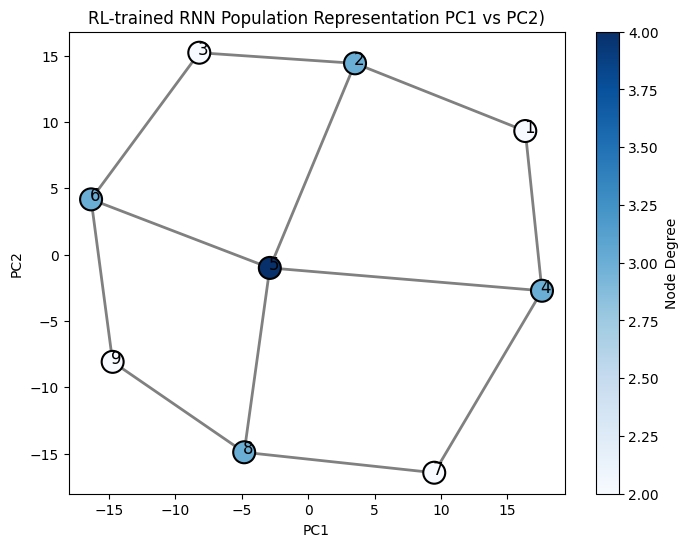

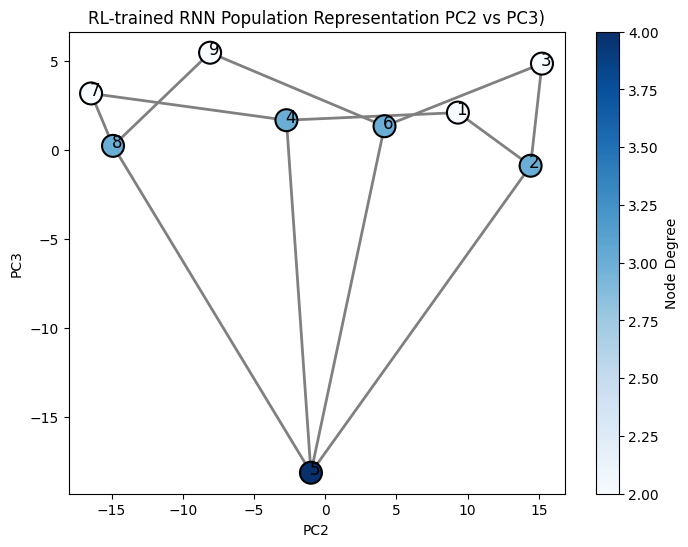

In [19]:
# Define node degrees for a 3x3 grid
node_degrees = {0: 2, 1: 3, 2: 2,
                3: 3, 4: 4, 5: 3,
                6: 2, 7: 3, 8: 2}
# Create an array of degrees corresponding to the nodes (0-8)
degrees = np.array([node_degrees[i] for i in range(9)])


text_offset = 0.1
# -----------------------------------------------
# Plot 1: Projection into PC1 and PC2 with degree-based colors
# -----------------------------------------------
fig1, ax1 = plt.subplots(figsize=(8, 6))
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], s=250, c=degrees, cmap='Blues', zorder = 3, edgecolors='black', linewidths=1.5)
for loc_idx, (x, y, _) in enumerate(X_pca):
    ax1.text(x-text_offset, y-text_offset, str(loc_idx+1), fontsize=12)
# Draw horizontal connections (maze rows)
for row in maze_rows:
    ax1.plot(X_pca[row, 0], X_pca[row, 1], color='grey', lw=2)
# Draw vertical connections (maze columns)
for col in maze_cols:
    ax1.plot(X_pca[col, 0], X_pca[col, 1], color='grey', lw=2)
ax1.set_title("RL-trained RNN Population Representation PC1 vs PC2)")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
plt.colorbar(scatter1, ax=ax1, label='Node Degree')
plt.show()

# -----------------------------------------------
# Plot 2: Projection into PC2 and PC3 with degree-based colors
# -----------------------------------------------
fig2, ax2 = plt.subplots(figsize=(8, 6))
scatter2 = ax2.scatter(X_pca[:, 1], X_pca[:, 2], s=250, c=degrees, cmap='Blues', zorder = 3, edgecolors='black', linewidths=1.5)
for loc_idx, (_, y, z) in enumerate(X_pca):
    ax2.text(y-text_offset, z-text_offset, str(loc_idx+1), fontsize=12)
# Draw horizontal connections (maze rows) using PC2 and PC3
for row in maze_rows:
    ax2.plot(X_pca[row, 1], X_pca[row, 2], color='grey', lw=2)
# Draw vertical connections (maze columns)
for col in maze_cols:
    ax2.plot(X_pca[col, 1], X_pca[col, 2], color='grey', lw=2)
ax2.set_title("RL-trained RNN Population Representation PC2 vs PC3)")
ax2.set_xlabel("PC2")
ax2.set_ylabel("PC3")
plt.colorbar(scatter2, ax=ax2, label='Node Degree')
plt.show()


/Users/AdamHarris/miniconda3/envs/par2vec/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


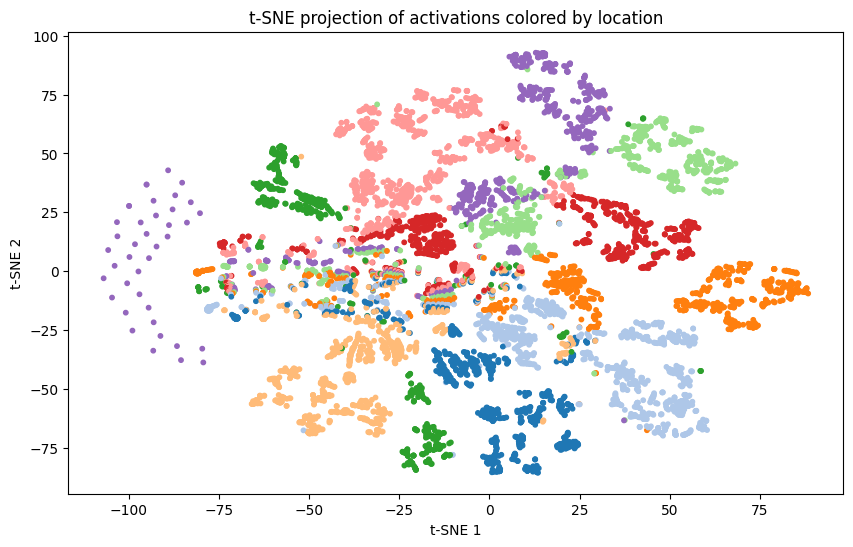

In [20]:
from sklearn.manifold import TSNE

# Combine all sessions into a single dataframe
combined_df = pd.concat(dataframes, ignore_index=True)

# Extract the activations from the combined dataframe
activations = np.array(combined_df['activation'].tolist())

# Perform t-SNE on the activations
tsne = TSNE(n_components=2, random_state=42)
embedding = tsne.fit_transform(activations)

# Map locations to colors
location_colors = {i: plt.cm.tab20(i) for i in range(9)}
colors = combined_df['location'].map(location_colors)

# Plot the t-SNE embedding
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=10)
plt.title('t-SNE projection of activations colored by location')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

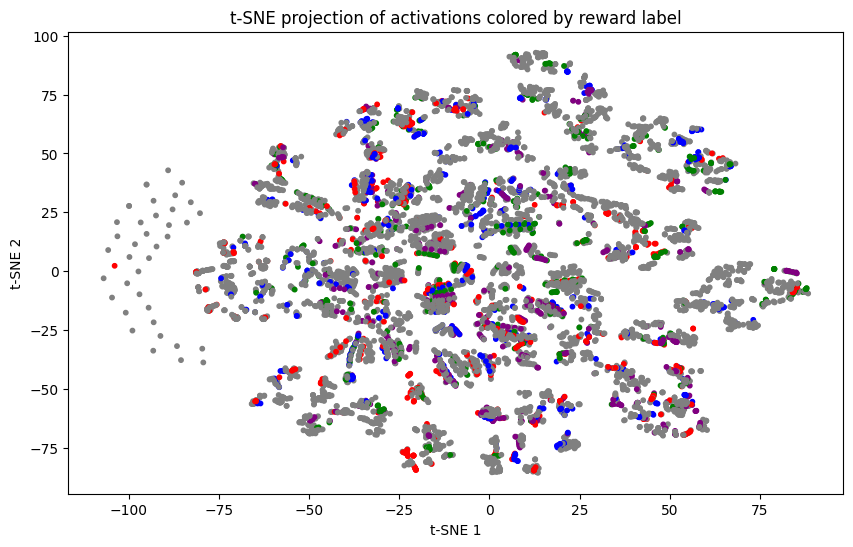

In [21]:
# Map reward labels to colors, grey if None
reward_colors = {'A': 'red', 'B': 'blue', 'C': 'green', 'D': 'purple', None: 'grey'}
colors = combined_df['reward_label'].map(reward_colors)

# Plot the t-SNE embedding
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=10)
plt.title('t-SNE projection of activations colored by reward label')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


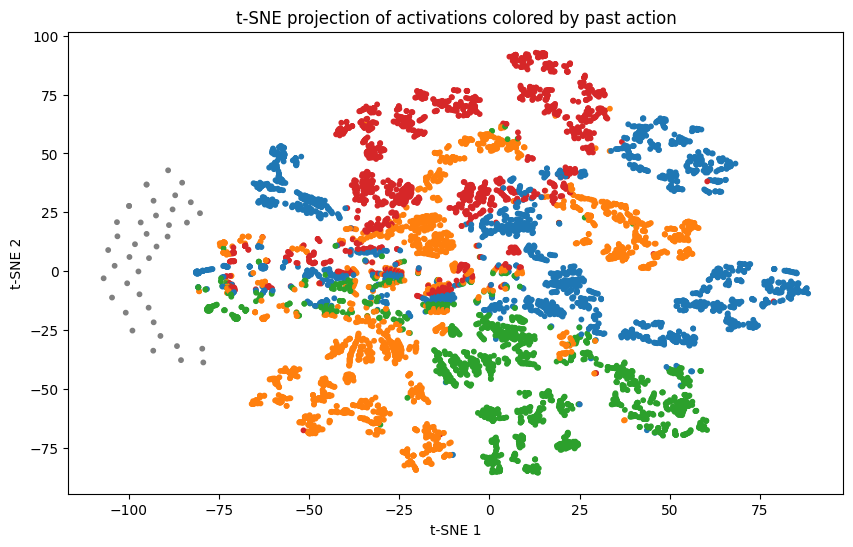

In [22]:
# Map actions to colors
action_colors = {i: plt.cm.tab10(i) for i in range(10)}
colors = combined_df['past_action'].map(action_colors)

# Replace NaN values with a default color (e.g., grey)
colors = colors.fillna('grey')

# Plot the t-SNE embedding
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=10)
plt.title('t-SNE projection of activations colored by past action')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


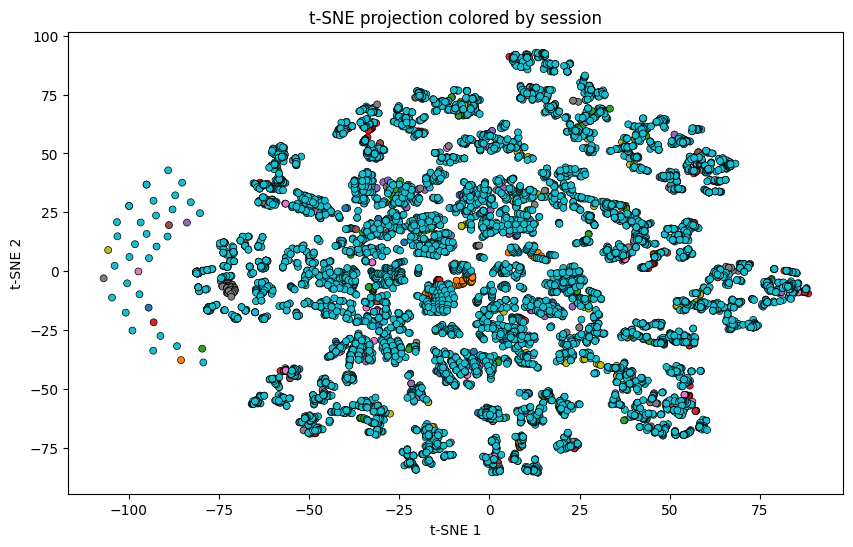

In [23]:
# Create a session label column in combined_df
combined_df['session'] = np.repeat(np.arange(len(dataframes)), [len(df) for df in dataframes])

# Map each session to a unique color using the tab10 colormap.
session_colors = {i: plt.cm.tab10(i) for i in range(len(dataframes))}
colors = combined_df['session'].map(session_colors)

# Plot the t-SNE embedding colored by session
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=25, edgecolors='k', linewidths=0.5)
plt.title('t-SNE projection colored by session')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


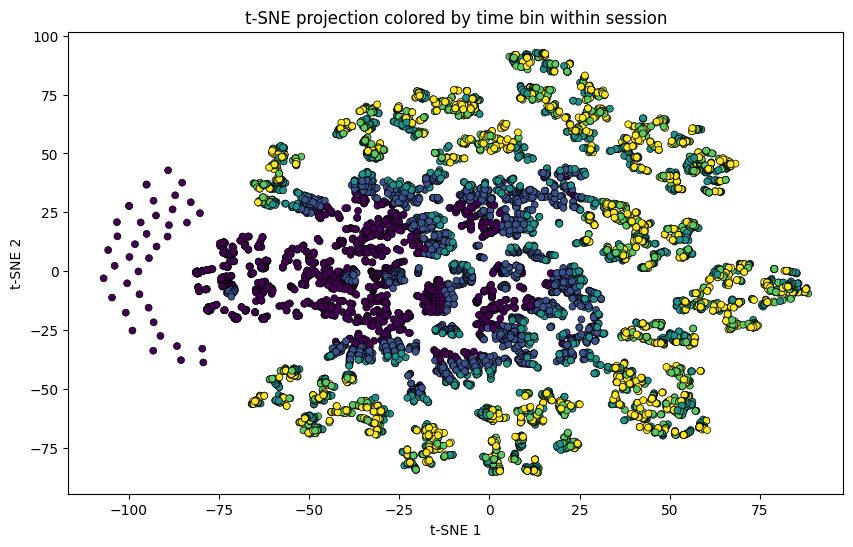

In [24]:
# Create time bins for each session. Here we use 5 bins per session.
num_bins = 5
combined_df['timebin'] = combined_df.groupby('session')['time'].transform(
    lambda x: pd.cut(x, bins=num_bins, labels=False)
)

# Normalize the bin number (0 to num_bins-1) to [0,1] for the colormap.
timebin_norm = combined_df['timebin'].astype(float) / (num_bins - 1)

# Use the viridis colormap for time bins.
colors = plt.cm.viridis(timebin_norm)

# Plot the t-SNE embedding colored by timebin within session.
plt.figure(figsize=(10, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=25, edgecolors='k', linewidths=0.5)
plt.title('t-SNE projection colored by time bin within session')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

/var/folders/fg/8ckmhq153z793vnzd_h_50s40000gn/T/ipykernel_98285/102774057.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df['time_to_next_reward'] = combined_df.groupby('session').apply(time_to_next_reward).reset_index(level=0, drop=True)


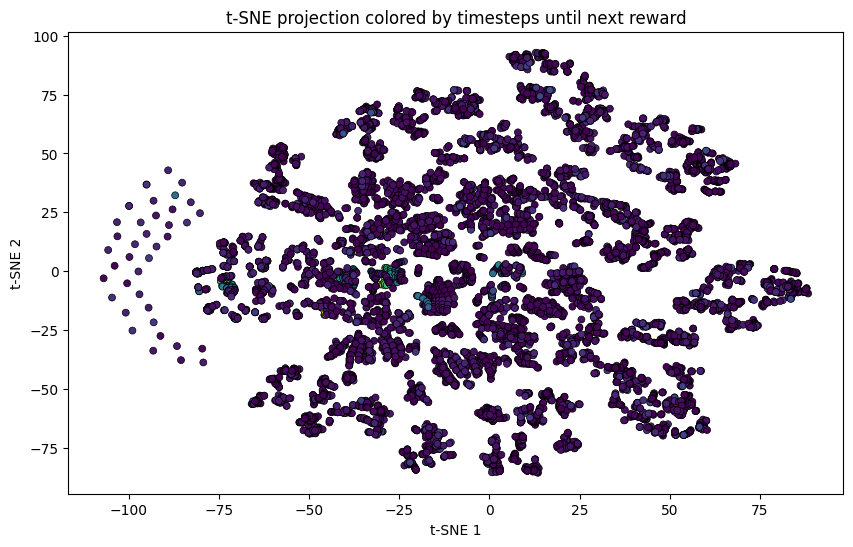

In [25]:
# Compute time until next reward for each session.
def time_to_next_reward(group):
    group = group.sort_values('time').copy()
    times = group['time'].values
    rewards = group['reward'].values
    ttr = np.empty_like(times, dtype=float)
    next_reward = np.nan
    # iterate backwards over the session
    for i in range(len(times)-1, -1, -1):
        if rewards[i] > 0:
            next_reward = times[i]
            ttr[i] = 0
        else:
            if np.isnan(next_reward):
                ttr[i] = np.nan  # no upcoming reward in this session
            else:
                ttr[i] = next_reward - times[i]
    return pd.Series(ttr, index=group.index)

# Apply per session and attach to combined_df
combined_df['time_to_next_reward'] = combined_df.groupby('session').apply(time_to_next_reward).reset_index(level=0, drop=True)

# Normalize the time-to-reward values (ignoring nan values)
min_val = combined_df['time_to_next_reward'].min()
max_val = combined_df['time_to_next_reward'].max()
norm_ttr = (combined_df['time_to_next_reward'] - min_val) / (max_val - min_val)

# Use the viridis colormap for the normalized values; fill nan with 0.
colors = plt.cm.viridis(norm_ttr.fillna(0))

# Plot the t-SNE embedding colored by timesteps until next reward
plt.figure(figsize=(10, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=25, edgecolors='k', linewidths=0.5)
plt.title('t-SNE projection colored by timesteps until next reward')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

/Users/AdamHarris/miniconda3/envs/par2vec/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/AdamHarris/miniconda3/envs/par2vec/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


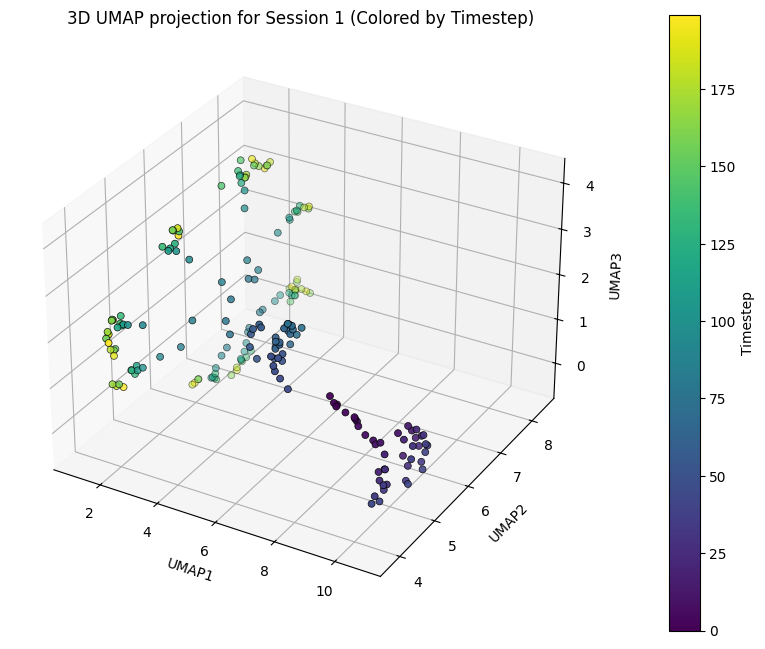

In [26]:
import umap
# Fi lter combined_df for session 1 only
session1_df = combined_df[combined_df['session'] == 1]

# Create a 3D UMAP embedding from the activations in session1_df
activations = np.array(session1_df['activation'].tolist())
umap_3d = umap.UMAP(n_components=3, random_state=42)
embedding_umap = umap_3d.fit_transform(activations)

# Use the 'time' column to color by timestep
timestep = session1_df['time']

# Plot the 3D UMAP embedding for session 1 colored by timestep
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embedding_umap[:, 0], embedding_umap[:, 1], embedding_umap[:, 2],
                     s=25, edgecolors='k', linewidths=0.5, c=timestep, cmap='viridis')
ax.set_title('3D UMAP projection for Session 1 (Colored by Timestep)')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

# Add a colorbar to show the timestep scale
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Timestep')

plt.show()


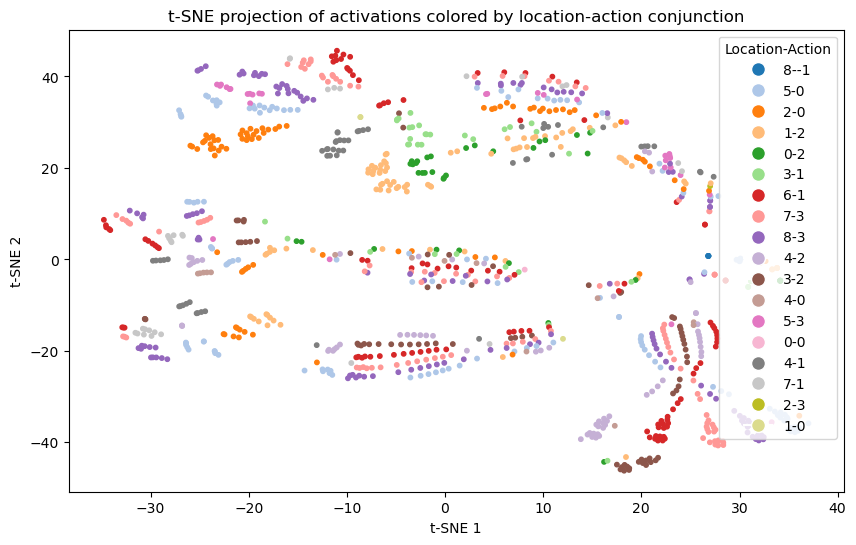

In [32]:
# Create a combined column for location and past action
combined_df['location_action'] = combined_df['location'].astype(str) + '-' + combined_df['past_action'].astype(str)

# Generate a unique color for each location-action combination
unique_combinations = combined_df['location_action'].unique()
combination_colors = {comb: plt.cm.tab20(i % 20) for i, comb in enumerate(unique_combinations)}

# Map the combined column to colors
colors = combined_df['location_action'].map(combination_colors)

# Plot the t-SNE embedding
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=10)

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=combination_colors[comb], markersize=10) for comb in unique_combinations]
plt.legend(handles, unique_combinations, title='Location-Action')

plt.title('t-SNE projection of activations colored by location-action conjunction')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


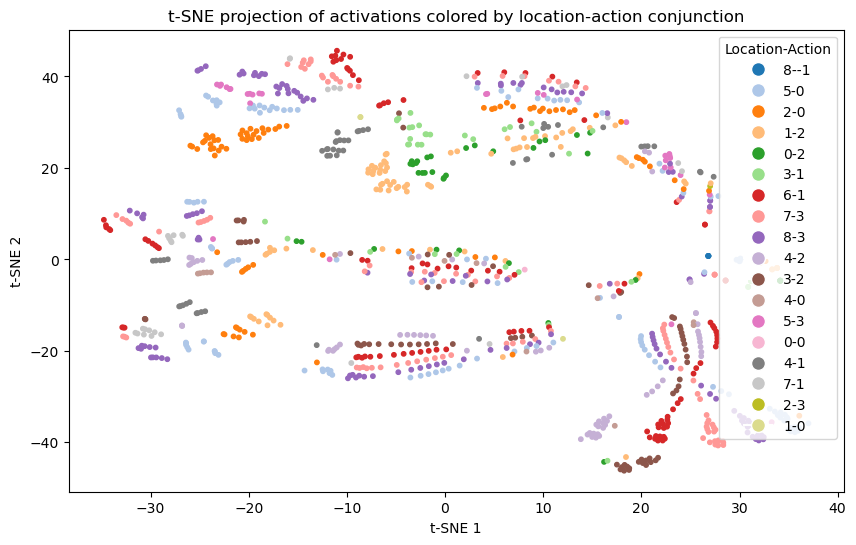

In [22]:
# Create a combined column for location and past action
combined_df['location_action'] = combined_df['location'].astype(str) + '-' + combined_df['past_action'].astype(str)

# Generate a unique color for each location-action combination
unique_combinations = combined_df['location_action'].unique()
combination_colors = {comb: plt.cm.tab20(i % 20) for i, comb in enumerate(unique_combinations)}

# Map the combined column to colors
colors = combined_df['location_action'].map(combination_colors)

# Plot the t-SNE embedding
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=10)

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=combination_colors[comb], markersize=10) for comb in unique_combinations]
plt.legend(handles, unique_combinations, title='Location-Action')

plt.title('t-SNE projection of activations colored by location-action conjunction')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()
